In [135]:
from onstove.raster import *
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import numpy as np
import psycopg2
from decouple import config
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, OPTICS
from rasterstats import zonal_stats

In [2]:
POSTGRES_USER = config('POSTGRES_USER')
POSTGRES_KEY = config('POSTGRES_KEY')

conn = psycopg2.connect(
   database="nepal", user=POSTGRES_USER, password=POSTGRES_KEY
)

In [3]:
pop_path = 'data/population_npl_2018-10-01_3857_100x100.tif'
with rasterio.open(pop_path) as src:
    population = src.read(1)
    population_meta = src.meta

## Clusering and urban/rural split

In [13]:
rows, cols = np.where(population>0)

In [14]:
x, y = rasterio.transform.xy(population_meta['transform'], 
                             rows, cols, 
                             offset='center')
coords = np.column_stack((x, y))

In [15]:
labels = DBSCAN(eps=500, min_samples=50).fit_predict(coords)
# labels = OPTICS(max_eps=300, min_samples=7, xi=.05, min_cluster_size=.05).fit_predict(coords)

In [22]:
clusters = population.copy()
clusters[rows, cols] = labels
clusters[np.isnan(clusters)] = -9999

In [130]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.int32,
                nodata=-9999)

with rasterio.open('data/clusters.tif', 'w', **out_meta) as dst:
    dst.write(clusters.astype(int), 1)

In [24]:
df = gpd.GeoDataFrame({'Population': population[rows, cols], 'Cluster': clusters[rows, cols], 
                       'geometry': gpd.points_from_xy(x, y)})

In [25]:
max_cluster = df['Cluster'].max()
cluster_number = df.loc[df['Cluster']==-1, 'Cluster'].count()

In [26]:
df.loc[df['Cluster']==-1, 'Cluster'] = [max_cluster + i for i in range(1, cluster_number + 1)]
df['Area'] = population_meta['transform'][0] * abs(population_meta['transform'][4]) / (1000 ** 2)
df_clusters = df.groupby('Cluster')[['Population', 'Area']].sum().reset_index()

In [27]:
calibrate_urban(df_clusters, 0.197, '')

Modelled urban ratio is 0.188% in comparision to the actual ratio of 0.197% after 1 iterations.


In [28]:
dff = df.merge(df_clusters[['Cluster', 'IsUrban']], on='Cluster', how='left')

In [29]:
isurban = population.copy()
isurban[rows, cols] = dff['IsUrban']
isurban[np.isnan(isurban)] = -9999

In [137]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.int32,
                nodata=-9999)

with rasterio.open('data/isurban.tif', 'w', **out_meta) as dst:
    dst.write(isurban.astype(int), 1)

## Tiers analysis

In [290]:
ntl, ntl_meta = align_raster(pop_path, 
                             'data/npp_2020_average_masked.tif',
                             method='average')

In [5]:
land_cover, land_cover_meta = align_raster(pop_path, 
                          'data/MCD12Q1_type1.tif',
                          method='nearest')

In [291]:
# npp_pop = (population>0) * (land_cover==13) * (npp>0.35) * npp
ntl_pop = (population>0) * (ntl>0) * ntl
# npp_pop[population>0] /= population[population>0]

In [292]:
sql = 'SELECT * FROM admin.npl_admbnda_adm0_nd_20201117'
adm0 = gpd.read_postgis(sql, conn)
shapes = ((g, 1) for g in adm0.to_crs(3857)['geom'].values)

with rasterio.open(pop_path) as src:
    mask = features.rasterize(
                shapes,
                out_shape=src.shape,
                transform=src.transform,
                all_touched=False,
                fill=0)
mask[population>0] = 1
ntl_pop[mask==0] = np.nan
ntl_pop[ntl_pop==0] = np.nan

ntl_urban = ntl_pop.copy()
ntl_urban[isurban!=2] = np.nan

ntl_periurban = ntl_pop.copy()
ntl_periurban[isurban!=1] = np.nan

ntl_rural = ntl_pop.copy()
ntl_rural[isurban!=0] = np.nan
# npp_pop_copy = npp_pop.copy()
# npp_pop_copy[npp_pop_copy==0] = -9999

In [293]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.float64,
                nodata=np.nan)

with rasterio.open('data/ntl_urban.tif', 'w', **out_meta) as dst:
    dst.write(ntl_urban, 1)

In [294]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.float64,
                nodata=np.nan)

with rasterio.open('data/ntl_periurban.tif', 'w', **out_meta) as dst:
    dst.write(ntl_periurban, 1)

In [295]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.float64,
                nodata=np.nan)

with rasterio.open('data/ntl_rural.tif', 'w', **out_meta) as dst:
    dst.write(ntl_rural, 1)

In [226]:
sql = 'SELECT * FROM admin.npl_admbnda_districts_nd_20201117'
df_district = gpd.read_postgis(sql, conn)
df_district.to_crs(3857, inplace=True)
# shapes = ((g, d) for g, d in zip(df_district['geom'].values, df_district['id'].values))

In [307]:
def get_tiers(raster_path, ntl, gdf):
    stats = ['percentile_20', 'percentile_40', 'percentile_60', 'percentile_80']
    result = zonal_stats(gdf, raster_path, 
                     stats=stats,
                     geojson_out=True)
    
    percentiles = gpd.GeoDataFrame.from_features(result)
    
    df = percentiles[stats].melt()
    medians = percentiles[stats].median()
    
    ax = sns.displot(df, x='value', hue='variable', kind="kde")
#     ax.set(xlim=(0, 2))
    
    tiers = ntl.copy()
    tiers[(ntl>0) & (ntl<medians['percentile_30'])] = 1
    tiers[(ntl>=medians['percentile_20']) & (ntl<medians['percentile_40'])] = 2
    tiers[(ntl>=medians['percentile_40']) & (ntl<medians['percentile_60'])] = 3
    tiers[(ntl>=medians['percentile_60']) & (ntl<medians['percentile_80'])] = 4
    tiers[(ntl>=medians['percentile_80'])] = 5
    tiers[np.isnan(tiers)] = 0
    
    return tiers

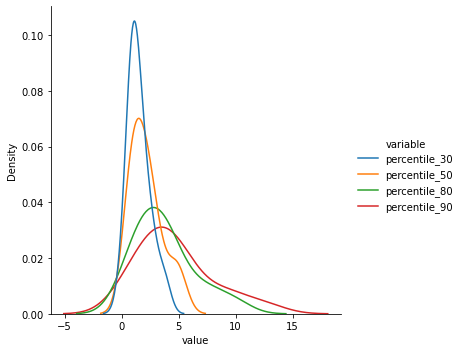

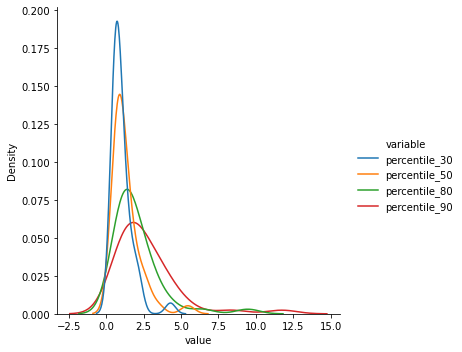

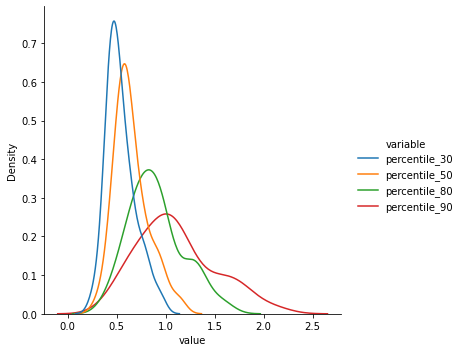

In [308]:
tiers_urban = get_tiers('data/ntl_urban.tif', ntl_urban, df_district)
tiers_periurban = get_tiers('data/ntl_periurban.tif', ntl_periurban, df_district)
tiers_rural = get_tiers('data/ntl_rural.tif', ntl_rural, df_district)

In [330]:
tiers = tiers_urban + tiers_periurban + tiers_rural

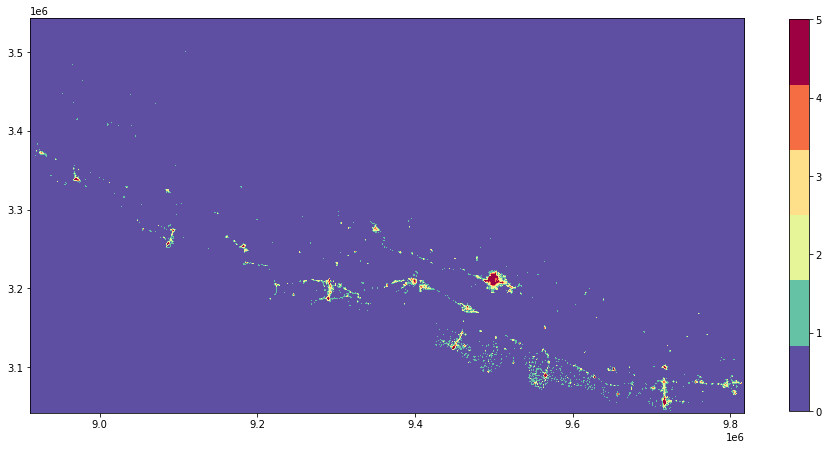

In [331]:
cmap = matplotlib.cm.get_cmap("Spectral_r", 6)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
cax = ax.imshow(tiers, extent=extent, cmap=cmap)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 1, 2, 3, 4, 5])
# fig.savefig(f"data/tiers.png", dpi=300, bbox_inches='tight')

In [314]:
np.nansum(population[tiers==5]) / np.nansum(population) * 100

20.315228851292723

In [324]:
np.nansum(population[tiers_urban==5]) / np.nansum(population) * 100

11.695217942185778

In [317]:
tiers[np.isnan(population)] = -9999
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.int32,
                nodata=-9999)

with rasterio.open('data/tiers3.tif', 'w', **out_meta) as dst:
    dst.write(tiers.astype(int), 1)

### This approach is not giving good results, so maybe we can calibrate the Tiers with a similar approach as the Urban / Rural split, but using NTL, population density and wealth index.